## Environment & Reproducibility

In [ ]:
import os, pickle, math, random, zipfile, requests, shutil
from pathlib import Path
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.utils.tensorboard import SummaryWriter

2025-08-14 16:11:46.779424: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-14 16:11:48.140990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-14 16:11:48.141050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-14 16:11:48.378286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-14 16:11:48.945530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

In [ ]:
# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Dataset Acquisition

In [ ]:
DATA_DIR = Path("tiny_imagenet")
ZIP_URL  = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"

def download_and_extract(url: str, root: Path) -> None:
    zip_path = root / "tiny-imagenet-200.zip"
    if not zip_path.exists():
        print("Downloading Tiny-ImageNet…")
        r = requests.get(url, stream=True)
        with open(zip_path, "wb") as f:
            shutil.copyfileobj(r.raw, f)
    if not (root / "tiny-imagenet-200").exists():
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(root)
    print("Dataset ready at", root)

download_and_extract(ZIP_URL, DATA_DIR)

Dataset ready at tiny_imagenet


In [ ]:
# Dataset constants
IMG_SIZE      = 64
NUM_CLASSES   = 20
BATCH_SIZE    = 64
EPOCHS        = 10
LEARNING_RATE = 3e-4

In [ ]:
# Transforms
from sklearn.model_selection import train_test_split


train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_tf  = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# %%
train_root = DATA_DIR / "tiny-imagenet-200" / "train"
train_full = torchvision.datasets.ImageFolder(root=str(train_root), transform=train_tf)

class_names = sorted(entry.name for entry in train_root.iterdir() if entry.is_dir())
selected_classes = class_names[:NUM_CLASSES]
class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
print("Selected classes:", selected_classes)

# Filter dataset
indices, targets = [], []
for idx, (_, label_idx) in enumerate(train_full.samples):
    cls = train_full.classes[label_idx]
    if cls in selected_classes:
        indices.append(idx)
        targets.append(class_to_idx[cls])

train_idx, test_idx = train_test_split(
    indices, test_size=0.2, stratify=targets, random_state=RANDOM_SEED
)

train_set = Subset(train_full, train_idx)
test_set  = Subset(train_full, test_idx)

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("\n\nTrain samples:", len(train_set), "\nTest samples:", len(test_set))

Selected classes: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695']


Train samples: 8000 
Test samples: 2000


### Dataset Visualisation

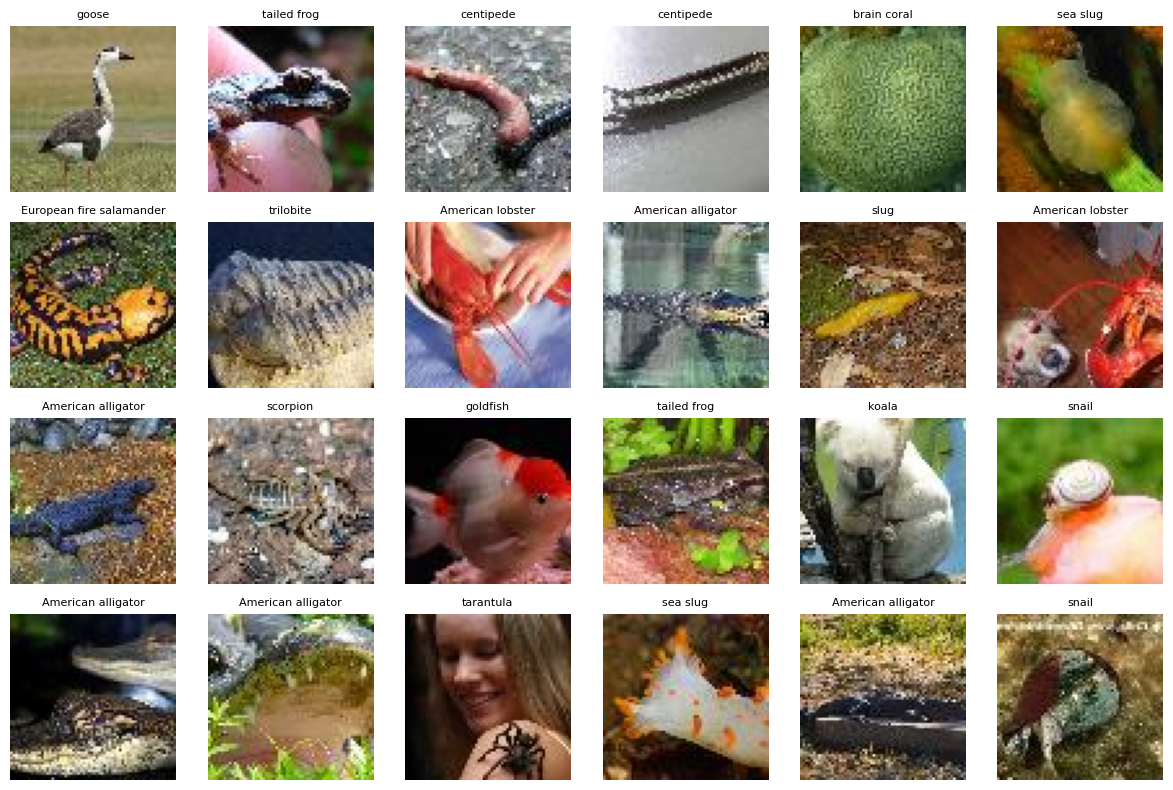

In [ ]:
# one-time: create a tiny dictionary from words.txt
import csv
wnid2name = {}
with open("tiny_imagenet/tiny-imagenet-200/words.txt") as f:
    for line in csv.reader(f, delimiter="\t"):
        wnid2name[line[0]] = line[1].split(",")[0]   # first synonym is fine

def plot_dataset_grid(dataset: Subset, rows: int = 4, cols: int = 6):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    full_dataset = dataset.dataset
    for i in range(rows * cols):
        idx_in_subset = np.random.randint(len(dataset))
        idx_in_full   = dataset.indices[idx_in_subset]
        img, orig_label_idx = full_dataset[idx_in_full]
        wnid   = full_dataset.classes[orig_label_idx]
        name   = wnid2name.get(wnid, wnid)   # fallback to ID if missing
        img    = img * 0.5 + 0.5
        axes[i].imshow(img.permute(1, 2, 0).numpy())
        axes[i].set_title(name, fontsize=8)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

plot_dataset_grid(train_set)

/tmp/ipykernel_29917/2753019449.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_classes, y=counts, palette="viridis")


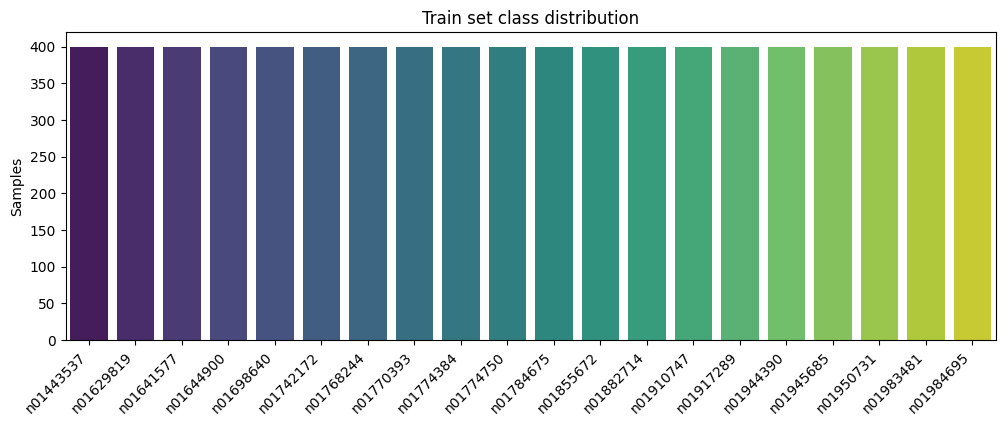

In [ ]:
# Class distribution
labels = [train_full.samples[i][1] for i in train_idx]
counts = np.bincount(labels, minlength=NUM_CLASSES)
plt.figure(figsize=(12,4))
sns.barplot(x=selected_classes, y=counts, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Train set class distribution")
plt.ylabel("Samples")
plt.show()

## Model Definitions

In [ ]:
class FCFNN(nn.Module):
    """
    Fully-connected feed-forward baseline.
    Flattens 64×64×3 images → 1024 → 512 → num_classes.
    """
    def __init__(self, input_size: int, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*input_size*input_size, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
    def forward(self, x): return self.net(x)

class CNN(nn.Module):
    """
    Small CNN: 3 conv blocks (32-64-128 channels) with 2×2 max-pool.
    Global average pooling → 512 → classes.
    """
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

class PatchEmbedding(nn.Module):
    """Split image into patches and project to embedding dim."""
    def __init__(self, img_size: int, patch_size: int, in_ch: int, embed_dim: int):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches  = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        # B, C, H, W -> B, D, N -> B, N, D
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ViT(nn.Module):
    """
    Minimal Vision Transformer.
    Args:
        num_classes: number of output classes
        embed_dim:   patch embedding dimension
        num_heads:   attention heads
        num_layers:  transformer layers
        patch_size:  square patch side length
        pos_embed:   {'learnable', 'fixed', 'none'}
    """
    def __init__(
        self,
        num_classes: int,
        embed_dim: int = 192,
        num_heads: int = 3,
        num_layers: int = 6,
        patch_size: int = 8,
        pos_embed: str = "learnable"
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(IMG_SIZE, patch_size, 3, embed_dim)
        n_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if pos_embed == "learnable":
            self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        elif pos_embed == "fixed":
            self.register_buffer("pos_embed", self._fixed_pos_embed(n_patches + 1, embed_dim))
        else:
            self.pos_embed = None

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=4 * embed_dim,
            activation="gelu", batch_first=True, dropout=0.1
        )
        self.blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def _fixed_pos_embed(self, seq_len: int, dim: int) -> torch.Tensor:
        pe = torch.zeros(seq_len, dim)
        pos = torch.arange(0, seq_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, dim, 2).float() * -(math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        return pe.unsqueeze(0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        return self.head(x[:, 0])

### Patch Embedding Visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.654902..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7647059..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3098039..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62352943..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..1.0].
Clipping input data to the 

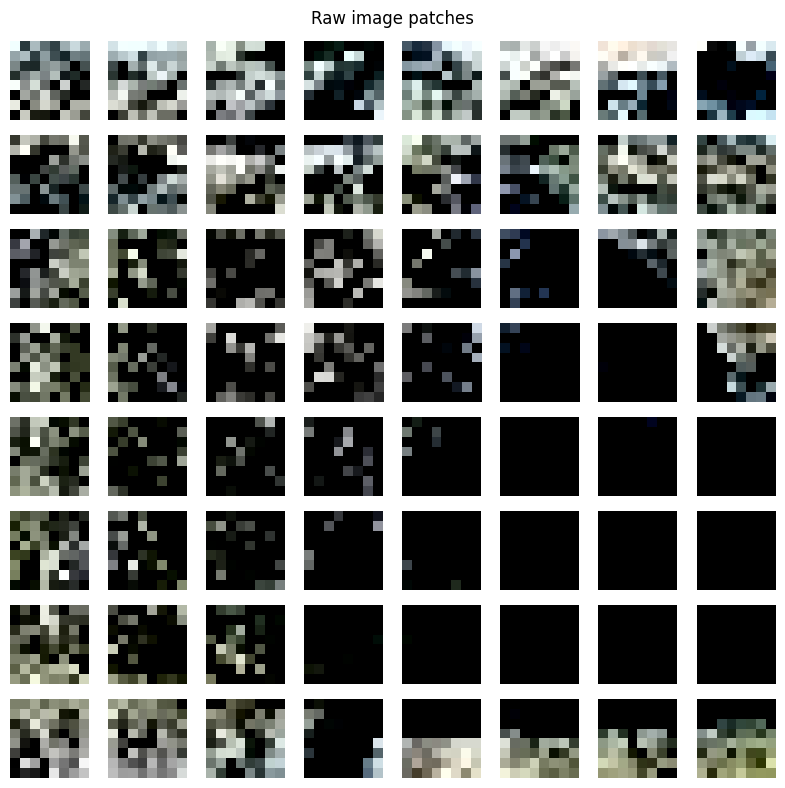

In [ ]:
def plot_patch_embedding(model: ViT, img: torch.Tensor, patch_size: int):
    """
    Visualise the raw patches (before linear projection) rather than the embedding.
    """
    model.eval()
    # unfold image to patches: (C, H, W) -> (C, N, P, P)
    c, h, w = img.shape
    patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(c, -1, patch_size, patch_size)  # (C, N, P, P)
    n_patches = patches.shape[1]
    grid = int(math.sqrt(n_patches))
    patches_np = patches.permute(1, 2, 3, 0).numpy()  # (N, P, P, C)

    fig, axes = plt.subplots(grid, grid, figsize=(grid, grid))
    axes = axes.flatten()
    for i in range(n_patches):
        axes[i].imshow(patches_np[i])
        axes[i].axis("off")
    plt.suptitle("Raw image patches")
    plt.tight_layout()
    plt.show()

sample_img, _ = train_set[0]
plot_patch_embedding(ViT(NUM_CLASSES), sample_img, 8)

## Training Utilities

In [ ]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    return running_loss / total, 100 * correct / total

@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    return running_loss / total, 100 * correct / total

In [ ]:
def train_and_eval(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    epochs: int,
    lr: float,
    name: str
) -> Dict[str, List[float]]:
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        te_loss, te_acc = evaluate(model, test_loader, criterion, device)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)
        print(f"{name} | epoch {epoch+1:02d} | "
              f"train {tr_acc:5.2f}% | test {te_acc:5.2f}%")
    return history

In [ ]:
## 5. Main Training

models = {
    "FCFNN": FCFNN(IMG_SIZE, NUM_CLASSES),
    "CNN":   CNN(NUM_CLASSES),
    "ViT":   ViT(NUM_CLASSES, num_heads=3, patch_size=8)
}
results = {}
for name, mdl in models.items():
    results[name] = train_and_eval(mdl, train_loader, test_loader, EPOCHS, LEARNING_RATE, name)

FCFNN | epoch 01 | train 19.41% | test 22.35%
FCFNN | epoch 02 | train 27.39% | test 24.55%
FCFNN | epoch 03 | train 31.57% | test 24.75%
FCFNN | epoch 04 | train 35.54% | test 25.10%
FCFNN | epoch 05 | train 39.35% | test 26.00%
FCFNN | epoch 06 | train 45.00% | test 25.30%
FCFNN | epoch 07 | train 50.09% | test 25.45%
FCFNN | epoch 08 | train 54.50% | test 25.85%
FCFNN | epoch 09 | train 59.94% | test 26.05%
FCFNN | epoch 10 | train 65.17% | test 25.20%
CNN | epoch 01 | train 11.68% | test 16.55%
CNN | epoch 02 | train 18.82% | test 19.85%
CNN | epoch 03 | train 21.60% | test 22.00%
CNN | epoch 04 | train 23.74% | test 23.10%
CNN | epoch 05 | train 25.12% | test 24.75%
CNN | epoch 06 | train 26.55% | test 24.75%
CNN | epoch 07 | train 27.74% | test 27.25%
CNN | epoch 08 | train 28.19% | test 26.50%
CNN | epoch 09 | train 29.15% | test 29.25%
CNN | epoch 10 | train 29.74% | test 29.05%
ViT | epoch 01 | train 16.71% | test 20.90%
ViT | epoch 02 | train 23.15% | test 24.90%
ViT | epoch 

## Results Visualisation

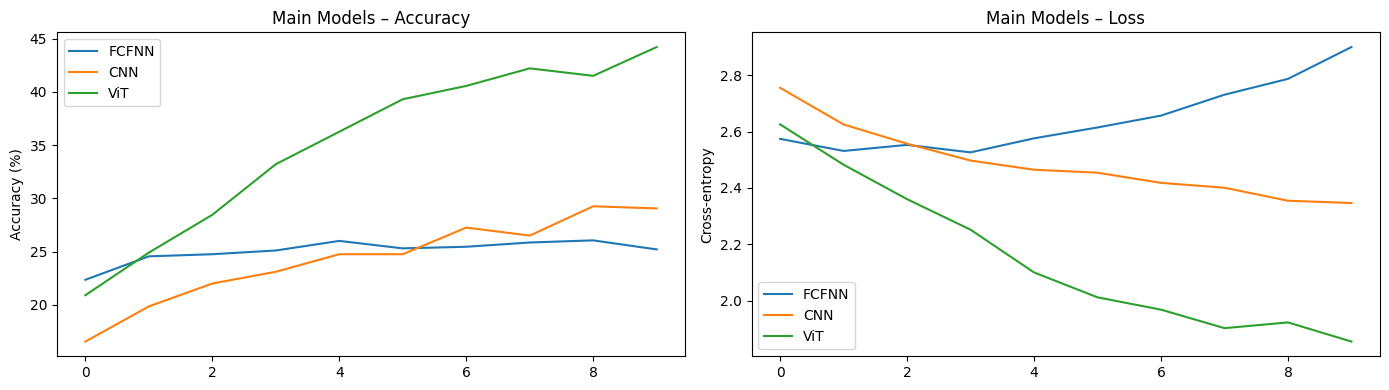

In [ ]:
def plot_results(results: Dict[str, Dict[str, List[float]]], title: str, fname: str):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    for name, h in results.items():
        ax[0].plot(h["test_acc"], label=name)
        ax[1].plot(h["test_loss"], label=name)
    ax[0].set_title(f"{title} – Accuracy")
    ax[0].set_ylabel("Accuracy (%)")
    ax[0].legend()
    ax[1].set_title(f"{title} – Loss")
    ax[1].set_ylabel("Cross-entropy")
    ax[1].legend()
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.show()

plot_results(results, "Main Models", "main_models.png")

## ViT Ablations

In [ ]:
ablation_results = {}

# 7.1 Number of heads
for heads in [1, 2, 4, 8]:
    mdl = ViT(NUM_CLASSES, num_heads=heads)
    ablation_results[f"heads={heads}"] = train_and_eval(
        mdl, train_loader, test_loader, EPOCHS, LEARNING_RATE, f"heads={heads}"
    )

# 7.2 Patch size
for ps in [4, 8, 16]:
    mdl = ViT(NUM_CLASSES, patch_size=ps)
    ablation_results[f"patch={ps}"] = train_and_eval(
        mdl, train_loader, test_loader, EPOCHS, LEARNING_RATE, f"patch={ps}"
    )

# 7.3 Positional embedding
for pos in ["none", "fixed", "learnable"]:
    mdl = ViT(NUM_CLASSES, pos_embed=pos)
    ablation_results[f"pos={pos}"] = train_and_eval(
        mdl, train_loader, test_loader, EPOCHS, LEARNING_RATE, f"pos={pos}"
    )

heads=1 | epoch 01 | train 16.77% | test 19.60%
heads=1 | epoch 02 | train 22.96% | test 25.50%
heads=1 | epoch 03 | train 26.23% | test 28.85%
heads=1 | epoch 04 | train 29.76% | test 28.15%
heads=1 | epoch 05 | train 32.84% | test 31.00%
heads=1 | epoch 06 | train 35.74% | test 33.05%
heads=1 | epoch 07 | train 37.42% | test 36.40%
heads=1 | epoch 08 | train 39.99% | test 35.55%
heads=1 | epoch 09 | train 42.02% | test 38.20%
heads=1 | epoch 10 | train 44.35% | test 40.05%
heads=2 | epoch 01 | train 16.25% | test 20.75%
heads=2 | epoch 02 | train 23.50% | test 24.35%
heads=2 | epoch 03 | train 27.46% | test 30.25%
heads=2 | epoch 04 | train 32.52% | test 35.15%
heads=2 | epoch 05 | train 37.09% | test 36.70%
heads=2 | epoch 06 | train 39.76% | test 37.55%
heads=2 | epoch 07 | train 42.75% | test 38.85%
heads=2 | epoch 08 | train 44.40% | test 39.80%
heads=2 | epoch 09 | train 47.01% | test 42.50%
heads=2 | epoch 10 | train 49.30% | test 42.00%
heads=4 | epoch 01 | train 17.50% | test

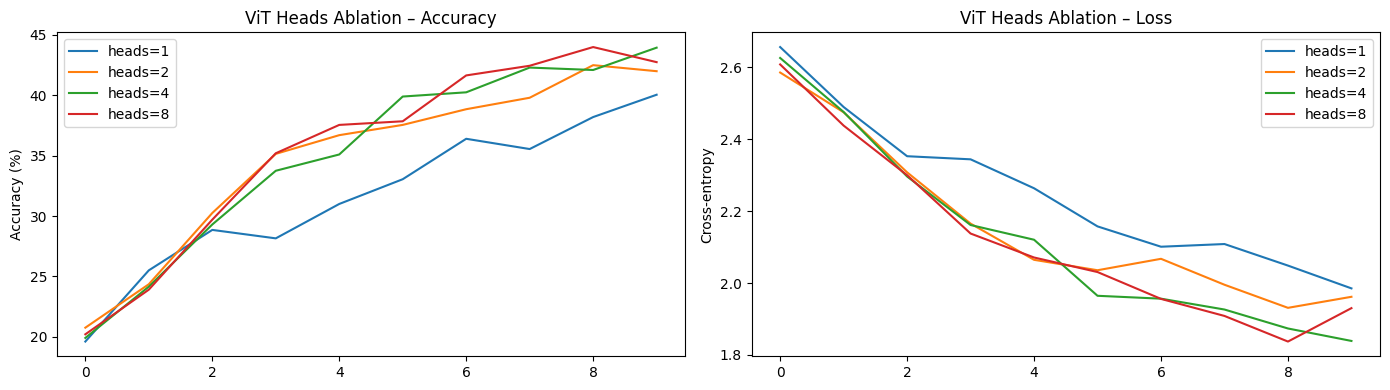

In [ ]:
plot_results({k: ablation_results[k] for k in ["heads=1","heads=2","heads=4","heads=8"]},
             "ViT Heads Ablation", "ablation_heads.png")

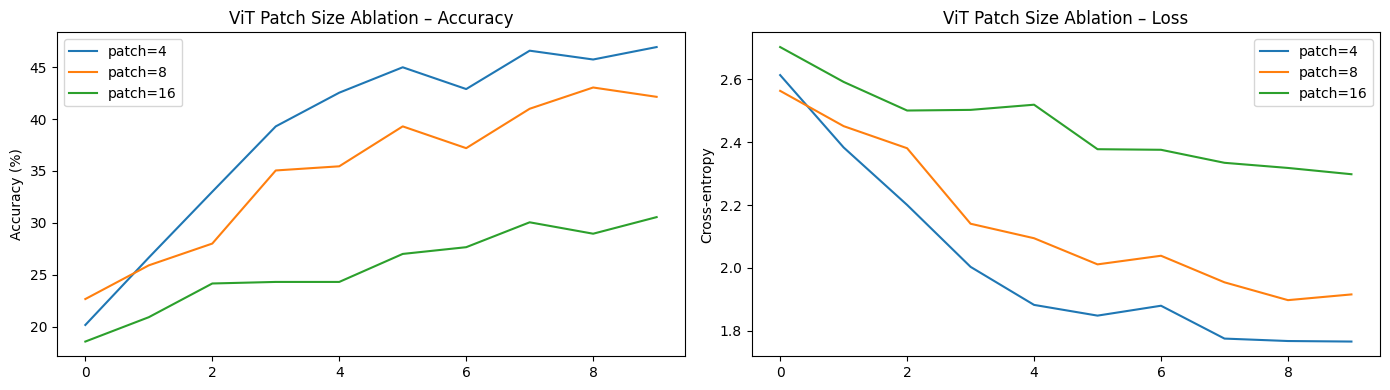

In [ ]:
plot_results({k: ablation_results[k] for k in ["patch=4","patch=8","patch=16"]},
             "ViT Patch Size Ablation", "ablation_patch.png")


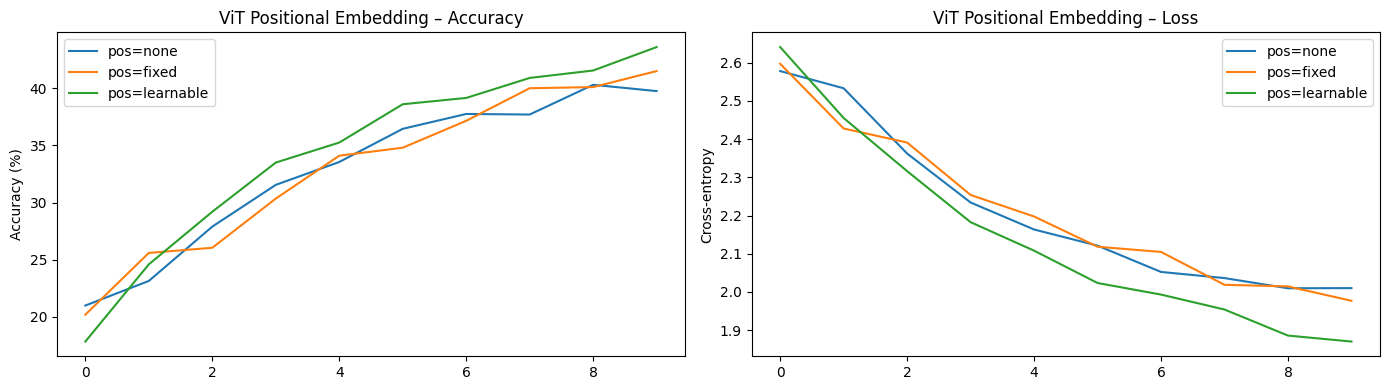

In [ ]:
plot_results({k: ablation_results[k] for k in ["pos=none","pos=fixed","pos=learnable"]},
             "ViT Positional Embedding", "ablation_pos.png")

## 8. Discussion & Difficulties of ViT
| Aspect | FCFNN | CNN | ViT |
|--------|-------|-----|-----|
| **Inductive bias** | None | Strong (locality, translation equivariance) | Minimal (global context only) |
| **Data efficiency** | Poor | Good | Poor w/o pretraining |
| **Convergence** | Fast | Fast | Slow, heavy regularisation needed |
| **Hyper-params** | Few | Moderate | Many (heads, layers, patch, embed, dropout, lr sched) |
| **Memory** | O(n) | O(hw) | O(n²) w.r.t. patches |
| **Interpretability** | None | Grad-CAM | Attention rollout possible |